In [ ]:
# nvidia-smi
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [ ]:

import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
import multiprocessing
import time
import warnings
import copy

from tqdm import tqdm
from torch import nn, Tensor
from torch.nn import Sequential as Seq, Linear, Parameter, ReLU
from torch_scatter import scatter
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, GCNConv, GATConv
from torch_geometric.utils import add_self_loops, degree
from utils.preprocessing_for_contour import create_data

In [ ]:
# load image file paths
svg_folder = './datasets/svg'
png_folder = './datasets/png'
imgs = []
png = []
dataset = []

for root, folders, files in os.walk(svg_folder):
    for file in files:
        if file.split('.')[1] != 'svg': continue
        if 'checkpoint' in file: continue
        
        file_path = os.path.join(svg_folder, file)
        imgs.append(file_path)
        
        file_path = os.path.join(png_folder, file.replace('svg', 'png'))
        png.append(file_path)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# for i, file_path in enumerate(tqdm(imgs)):
#     try:
#         dataset.append(create_data(file_path))
#     except:
#         print(file_path) 
#         raise SystemExit
        
#     # file_path = "./datasets/svg/001-candle-230122.svg"
#     # data = create_data(file_path)
#     # print(data)
#     # break

In [ ]:
# imgs = imgs[:2000]
# warnings.filterwarnings("ignore")
# dataset = []
# for data in tqdm(multiprocessing.Pool(8).imap_unordered(create_data, imgs), total=len(imgs)):
#     dataset.append(data)
    
# # imgs = imgs[:2000]
# # dataset = []
# # for img in tqdm(imgs):
# #     data = create_data(img)
# #     dataset.append(data)

In [ ]:
imgs_1 = imgs[:2000]
imgs_2 = imgs[2000:4000]
imgs_3 = imgs[4000:6000]
imgs_4 = imgs[6000:]
warnings.filterwarnings("ignore")
dataset = []
for data in tqdm(multiprocessing.Pool(8).imap_unordered(create_data, imgs_1), total=len(imgs_1)):
    if len(data) != 0:
        dataset.append(data)

In [ ]:
for data in tqdm(multiprocessing.Pool(8).imap_unordered(create_data, imgs_2), total=len(imgs_2)):
    if len(data) != 0:
        dataset.append(data)

In [ ]:
for data in tqdm(multiprocessing.Pool(8).imap_unordered(create_data, imgs_3), total=len(imgs_3)):
    if len(data) != 0:
        dataset.append(data)

In [ ]:
for d in tqdm(imgs_4):
    data = create_data(d)
    if len(data) != 0:
        dataset.append(data)

In [ ]:
# hyperparameters
torch.manual_seed(16)
np.random.seed(16)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 1

_train = int(len(dataset) * 0.9)
_val = _train + int(len(dataset) * 0.05)
_test = len(dataset) - _val

# create dataloader
train_set, val_set, test_set = dataset[:_train], dataset[_train:_val], dataset[_val:]
train_svg, val_svg, test_svg = imgs[:_train], imgs[_train:_val], imgs[_val:]
train_png, val_png, test_png = png[:_train], png[_train:_val], png[_val:]

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

print(f"Training Data: {len(train_set)}\nValidation Data: {len(val_set)}\nTesting Data: {len(test_set)}")

In [26]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(2, 16, improved=True)
        self.conv2 = GCNConv(16, 64, improved=True)
        self.fc1 = nn.Linear(64, 16)
        self.fc2 = nn.Linear(16, 2)
        
    def forward(self, data):
        x, edge_index = copy.deepcopy(data.x), data.edge_index
        num = int(data.cluster[-1]) + 1
        start = 0
        for i in range(num):
            points = x[data.cluster==i]
            cnt = len(points)
            _min, _max = torch.min(points[:,3:], dim=0).values, torch.max(points[:,3:], dim=0).values
            # x[start:start+cnt,3:] = 16 * (x[start:start+cnt,3:] - _min) / (_max - _min)
            x[start:start+cnt,3:] = 10 * x[start:start+cnt,3:] - _min * 16
            start = start + cnt
            
        x = x[:,3:]
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        x = scatter(x, data.cluster, dim=0, reduce='mean')
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return torch.sigmoid(x)
    
def loss_fn(out, target, cluster):
    _, unique_counts = np.unique(cluster.cpu(), return_counts=True)
    res = torch.from_numpy(unique_counts).to(device)
    mse = (out - target) ** 2
    loss = torch.sum(torch.mean(mse, dim=1))# / res * 100)
    return loss

In [27]:
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # ori lr=0.01
criterion = torch.nn.MSELoss(reduction='sum')

In [28]:
# training
train_losses = []
val_losses = []
best_loss = float('inf')
num_epoch = 50

for epoch in range(num_epoch):  # num_epoch
    train_loss = 0
    val_loss = 0
    train_err = 0
    val_err = 0
    
    model.train()
    for data in tqdm(train_loader): 
        data = data.to(device)    
        if data.x.shape[0] == 0:
            train_err += 1
            continue
        
        optimizer.zero_grad()    
        out = model(data)
        lab = scatter(data.lab, data.cluster, dim=0, reduce='mean')[:, 1:]
        loss = loss_fn(out, lab, data.cluster)
        # loss = criterion(out, lab)
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    model.eval()
    for data in tqdm(val_loader):
        data = data.to(device)
        if data.x.shape[0] == 0:
            val_err += 1
            continue
        
        out = model(data)        
        lab = scatter(data.lab, data.cluster, dim=0, reduce='mean')[:, 1:]
        loss = loss_fn(out, lab, data.cluster)
        # loss = criterion(out, lab)
        
        val_loss += loss.item()
    
    train_avg = train_loss / (len(train_loader)-train_err)
    val_avg = val_loss / (len(val_loader)-val_err)
    train_losses.append(train_avg)
    val_losses.append(val_avg)
    
    print(f'Epoch {epoch}\tTraining Loss: {train_avg}\tValidation Loss: {val_avg}')
    
    if val_avg < best_loss:
        print(f'(Epoch={epoch}) Validation Loss Decreased({best_loss:.6f}--->{val_avg:.6f})\tSaving The Model')
        best_loss = val_avg
        torch.save(model.state_dict(), 'best_checkpoint.pth')

100%|██████████| 540/540 [00:02<00:00, 253.17it/s]


Epoch 0	Training Loss: 0.20046248762055865	Validation Loss: 0.21259120934884304
(Epoch=0) Validation Loss Decreased(inf--->0.212591)	Saving The Model


100%|██████████| 540/540 [00:02<00:00, 249.79it/s]


Epoch 1	Training Loss: 0.2003646528176603	Validation Loss: 0.2136404920205543


100%|██████████| 540/540 [00:02<00:00, 254.00it/s]


Epoch 2	Training Loss: 0.20010316484607565	Validation Loss: 0.21276583542650634


100%|██████████| 540/540 [00:02<00:00, 248.39it/s]


Epoch 3	Training Loss: 0.2003394113151519	Validation Loss: 0.21690699773047256


100%|██████████| 540/540 [00:02<00:00, 251.51it/s]


Epoch 4	Training Loss: 0.20036365380261884	Validation Loss: 0.21328090069884503


100%|██████████| 540/540 [00:02<00:00, 245.92it/s]


Epoch 5	Training Loss: 0.20001109847784057	Validation Loss: 0.21464461206837937


100%|██████████| 540/540 [00:02<00:00, 250.73it/s]


Epoch 6	Training Loss: 0.20015356157366135	Validation Loss: 0.21493884176791955


100%|██████████| 540/540 [00:02<00:00, 251.99it/s]


Epoch 7	Training Loss: 0.20038319853133987	Validation Loss: 0.2125945317386477


100%|██████████| 540/540 [00:02<00:00, 254.38it/s]


Epoch 8	Training Loss: 0.20019264578518653	Validation Loss: 0.21621255291177444


100%|██████████| 540/540 [00:02<00:00, 253.33it/s]


Epoch 9	Training Loss: 0.20032036843553813	Validation Loss: 0.21302907007694658


100%|██████████| 540/540 [00:02<00:00, 244.43it/s]


Epoch 10	Training Loss: 0.20031576844424046	Validation Loss: 0.21518387085740903


100%|██████████| 540/540 [00:02<00:00, 253.95it/s]


Epoch 11	Training Loss: 0.200134786751215	Validation Loss: 0.21503271793869014


100%|██████████| 540/540 [00:02<00:00, 249.83it/s]


Epoch 12	Training Loss: 0.2002730873939375	Validation Loss: 0.21301666007170247


100%|██████████| 540/540 [00:02<00:00, 253.40it/s]


Epoch 13	Training Loss: 0.20031709403290615	Validation Loss: 0.21407849775730736


100%|██████████| 540/540 [00:02<00:00, 253.48it/s]


Epoch 14	Training Loss: 0.20043111251799686	Validation Loss: 0.21243408676064401
(Epoch=14) Validation Loss Decreased(0.212591--->0.212434)	Saving The Model


100%|██████████| 540/540 [00:02<00:00, 253.54it/s]


Epoch 15	Training Loss: 0.20020767187299293	Validation Loss: 0.21253302604977595


100%|██████████| 540/540 [00:02<00:00, 246.66it/s]


Epoch 16	Training Loss: 0.20036654410554888	Validation Loss: 0.2151810835702


100%|██████████| 540/540 [00:02<00:00, 250.82it/s]


Epoch 17	Training Loss: 0.20039938786863337	Validation Loss: 0.21355051745108708


100%|██████████| 540/540 [00:02<00:00, 248.38it/s]


Epoch 18	Training Loss: 0.20042846446263934	Validation Loss: 0.21226041240669374
(Epoch=18) Validation Loss Decreased(0.212434--->0.212260)	Saving The Model


100%|██████████| 540/540 [00:02<00:00, 253.70it/s]


Epoch 19	Training Loss: 0.20016412937412909	Validation Loss: 0.2131332014126841


100%|██████████| 540/540 [00:02<00:00, 250.92it/s]


Epoch 20	Training Loss: 0.20045681559573075	Validation Loss: 0.21224055149833912
(Epoch=20) Validation Loss Decreased(0.212260--->0.212241)	Saving The Model


100%|██████████| 540/540 [00:02<00:00, 246.51it/s]


Epoch 21	Training Loss: 0.20015349082870873	Validation Loss: 0.21232835384499696


100%|██████████| 540/540 [00:02<00:00, 254.31it/s]


Epoch 22	Training Loss: 0.20037332839752703	Validation Loss: 0.21325337002053857


100%|██████████| 540/540 [00:02<00:00, 254.08it/s]


Epoch 23	Training Loss: 0.20038867622282133	Validation Loss: 0.21265249224465893


100%|██████████| 540/540 [00:02<00:00, 250.60it/s]


Epoch 24	Training Loss: 0.20025664290053483	Validation Loss: 0.2128792507686066


100%|██████████| 540/540 [00:02<00:00, 250.74it/s]


Epoch 25	Training Loss: 0.20021458636015407	Validation Loss: 0.21266325952968113


100%|██████████| 540/540 [00:02<00:00, 253.64it/s]


Epoch 26	Training Loss: 0.20019612658889324	Validation Loss: 0.21354881100598033


100%|██████████| 540/540 [00:02<00:00, 254.33it/s]


Epoch 27	Training Loss: 0.2004387468722339	Validation Loss: 0.2125637997743777


100%|██████████| 540/540 [00:02<00:00, 249.77it/s]


Epoch 28	Training Loss: 0.20056671351128563	Validation Loss: 0.2129975073746647


100%|██████████| 540/540 [00:02<00:00, 254.33it/s]


Epoch 29	Training Loss: 0.2001607261439251	Validation Loss: 0.21231158857958185


100%|██████████| 540/540 [00:02<00:00, 250.73it/s]


Epoch 30	Training Loss: 0.20049707599009584	Validation Loss: 0.21469095144765796


100%|██████████| 540/540 [00:02<00:00, 253.87it/s]


Epoch 31	Training Loss: 0.20012374055019297	Validation Loss: 0.21832543542496516


100%|██████████| 540/540 [00:02<00:00, 253.76it/s]


Epoch 32	Training Loss: 0.20046870597399716	Validation Loss: 0.21324779336961608


100%|██████████| 540/540 [00:02<00:00, 253.97it/s]


Epoch 33	Training Loss: 0.20039385898242762	Validation Loss: 0.21420446367960216


100%|██████████| 540/540 [00:02<00:00, 253.44it/s]


Epoch 34	Training Loss: 0.20039705606214514	Validation Loss: 0.21264204073317902


100%|██████████| 540/540 [00:02<00:00, 253.90it/s]


Epoch 35	Training Loss: 0.2002503249164918	Validation Loss: 0.21301535065285862


100%|██████████| 540/540 [00:02<00:00, 254.31it/s]


Epoch 36	Training Loss: 0.20042909769482142	Validation Loss: 0.2143226765048759


100%|██████████| 540/540 [00:02<00:00, 254.31it/s]


Epoch 37	Training Loss: 0.20051137971808192	Validation Loss: 0.21230260844739085


100%|██████████| 540/540 [00:02<00:00, 254.11it/s]


Epoch 38	Training Loss: 0.2003619381127795	Validation Loss: 0.21238547134195904


100%|██████████| 540/540 [00:02<00:00, 254.06it/s]


Epoch 39	Training Loss: 0.2008396101705135	Validation Loss: 0.2132858987354363


100%|██████████| 540/540 [00:02<00:00, 243.29it/s]


Epoch 40	Training Loss: 0.20036166115098475	Validation Loss: 0.2122419312570451


100%|██████████| 540/540 [00:02<00:00, 250.92it/s]


Epoch 41	Training Loss: 0.200379169038429	Validation Loss: 0.2166689369810262


100%|██████████| 540/540 [00:02<00:00, 250.56it/s]


Epoch 42	Training Loss: 0.20026209856469387	Validation Loss: 0.21366467872651776


100%|██████████| 540/540 [00:02<00:00, 252.09it/s]


Epoch 43	Training Loss: 0.2003702461081829	Validation Loss: 0.21339535338338464


100%|██████████| 540/540 [00:02<00:00, 253.70it/s]


Epoch 44	Training Loss: 0.20037084902878982	Validation Loss: 0.2129143164337923


100%|██████████| 540/540 [00:02<00:00, 253.55it/s]


Epoch 45	Training Loss: 0.2002466268978604	Validation Loss: 0.21288139955485585


100%|██████████| 540/540 [00:02<00:00, 253.46it/s]


Epoch 46	Training Loss: 0.20040704231072157	Validation Loss: 0.21313783260476257


100%|██████████| 540/540 [00:02<00:00, 247.18it/s]


Epoch 47	Training Loss: 0.2002675711549467	Validation Loss: 0.21825438768395947


100%|██████████| 540/540 [00:02<00:00, 248.91it/s]


Epoch 48	Training Loss: 0.20045132236383054	Validation Loss: 0.21238907845432145


100%|██████████| 540/540 [00:02<00:00, 254.05it/s]

Epoch 49	Training Loss: 0.2004347004683745	Validation Loss: 0.2132195048301515


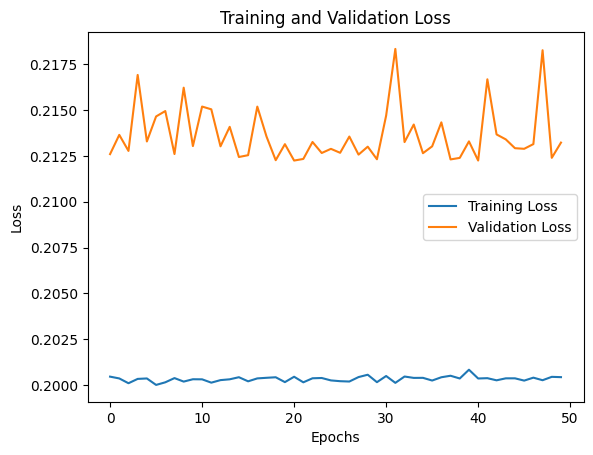

In [29]:
# plot losses
import matplotlib.pyplot as plt

_x = list(range(num_epoch))
plt.plot(_x, train_losses, label='Training Loss')
plt.plot(_x, val_losses, label='Validation Loss')
 
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
# # testing
# model.load_state_dict(torch.load('./best_checkpoint.pth'))
# model.eval()

# test_loss = 0
# for i, data in enumerate(tqdm(test_loader)):
#     data = data.to(device)
#     out = model(data)
#     loss = criterion(out, data.rgb)
#     test_loss += loss.item()
    
# print(f'Testing Loss: {test_loss / len(test_loader)}')

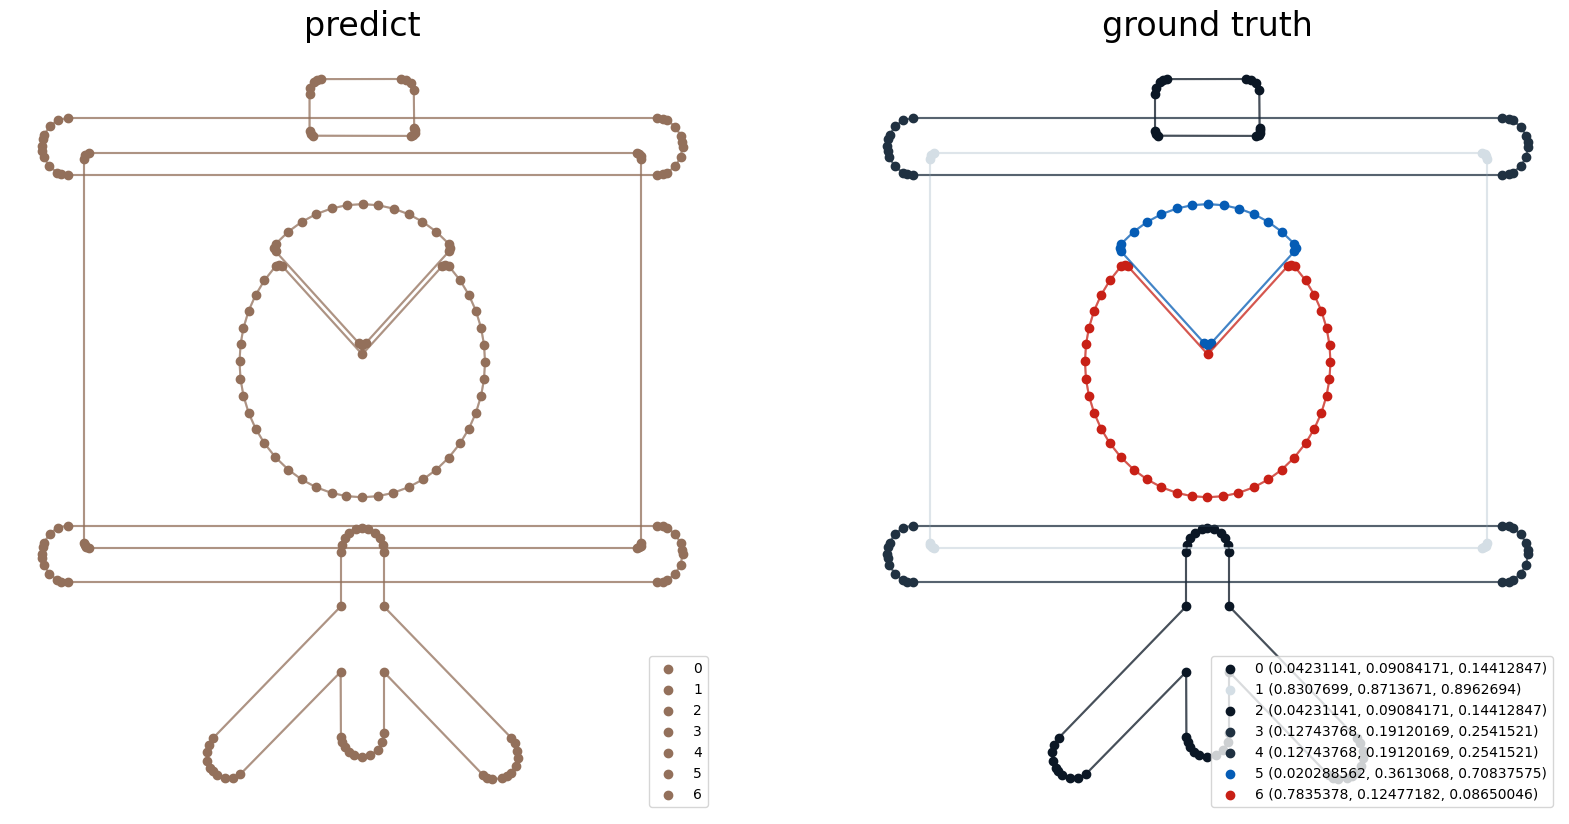

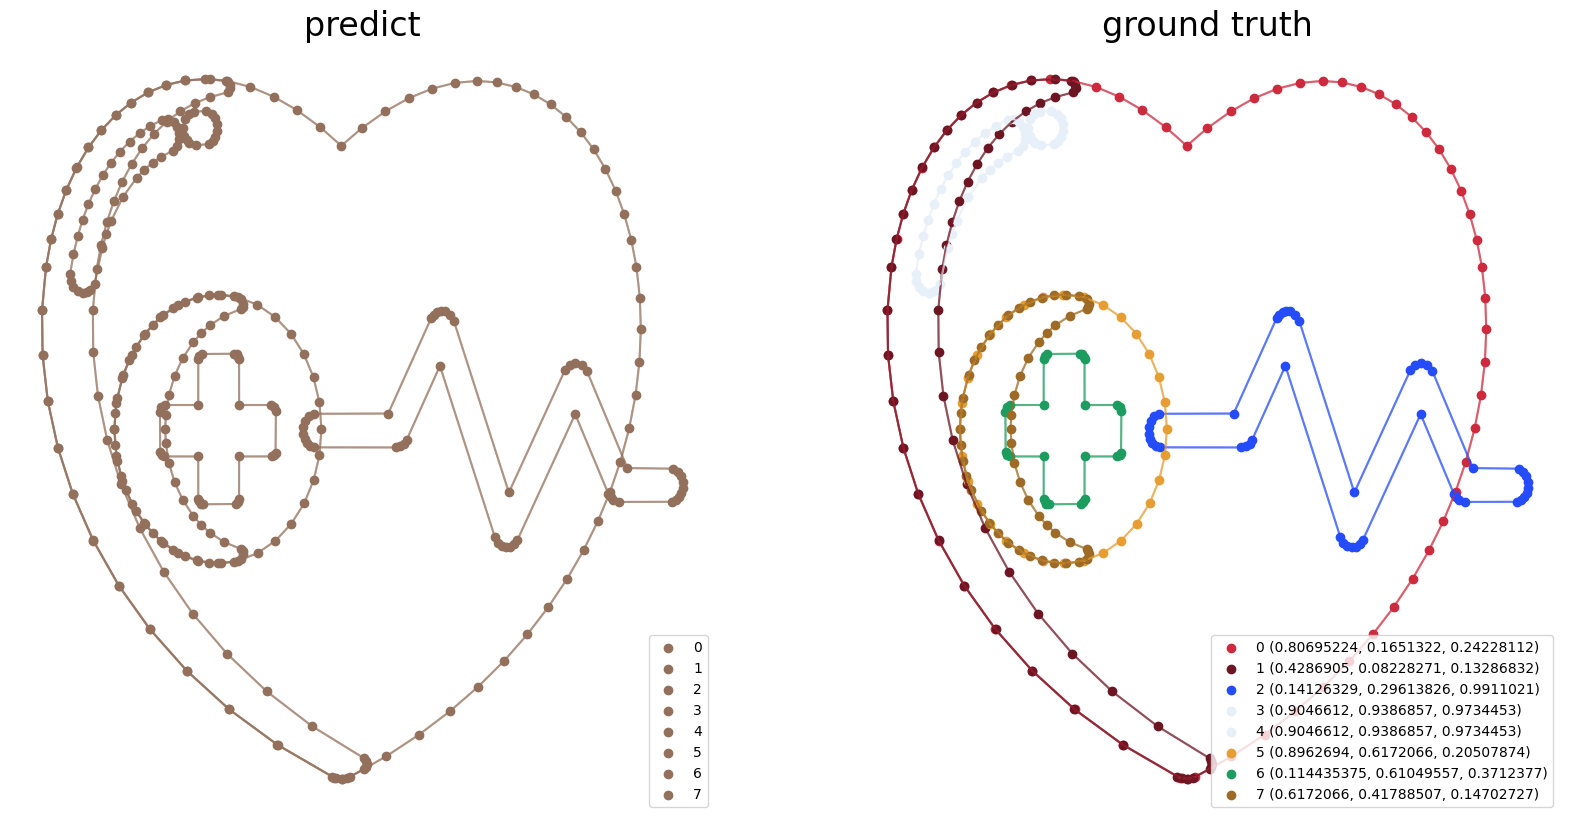

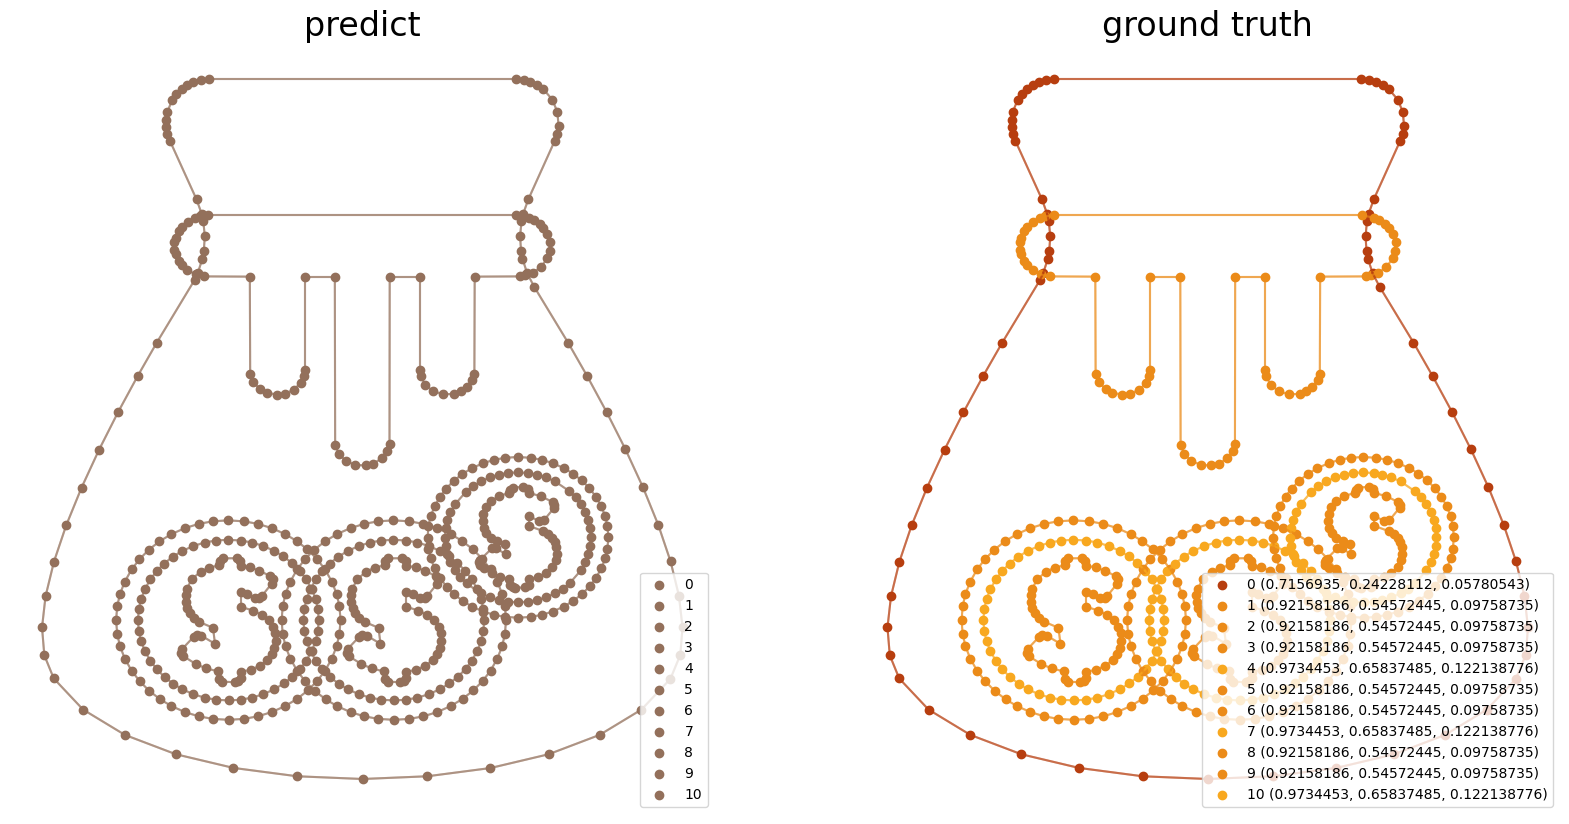

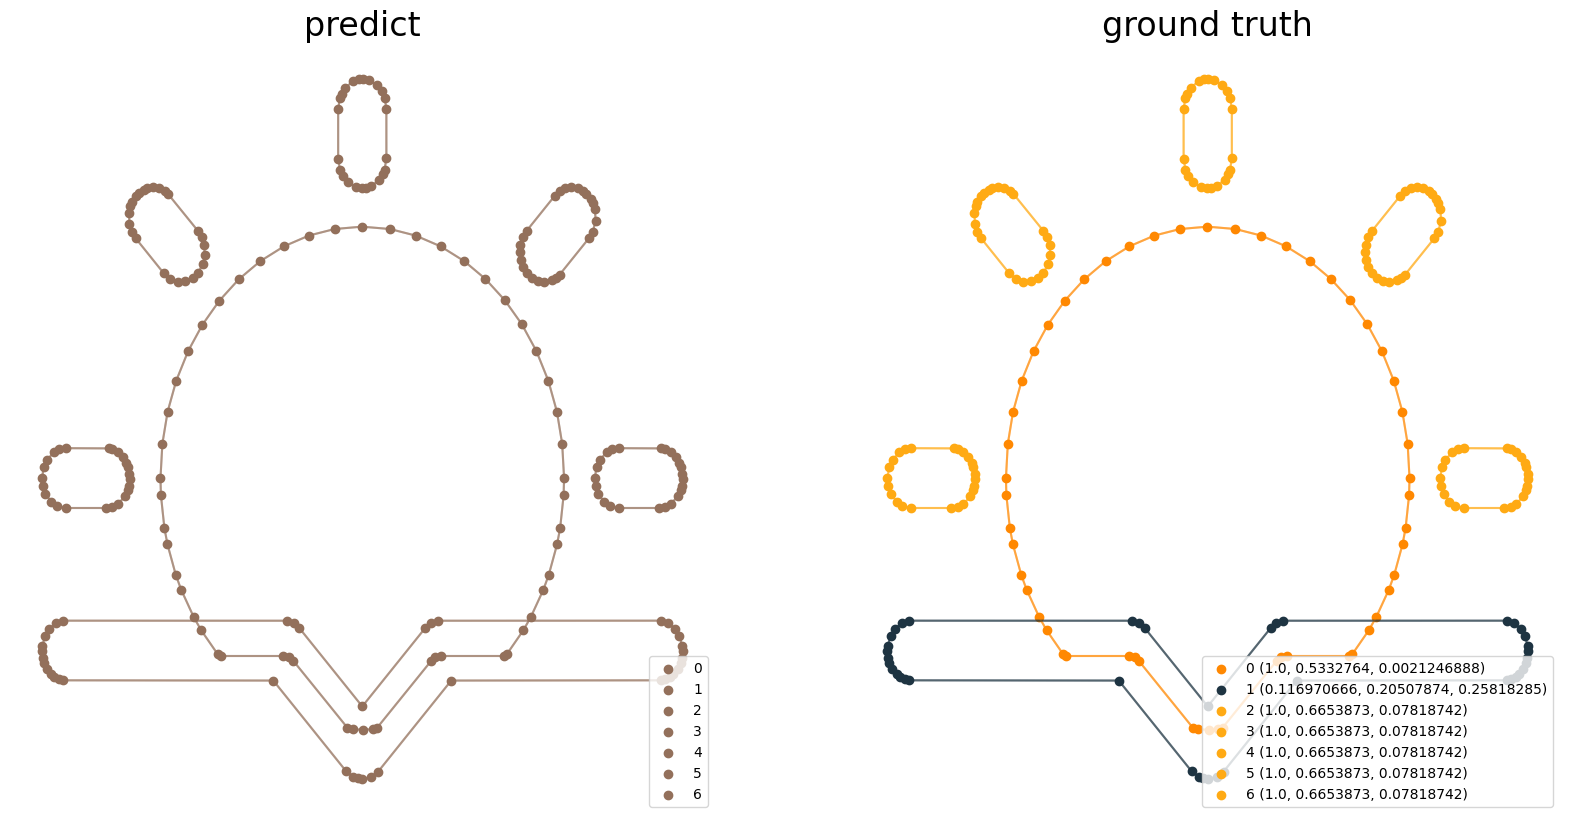

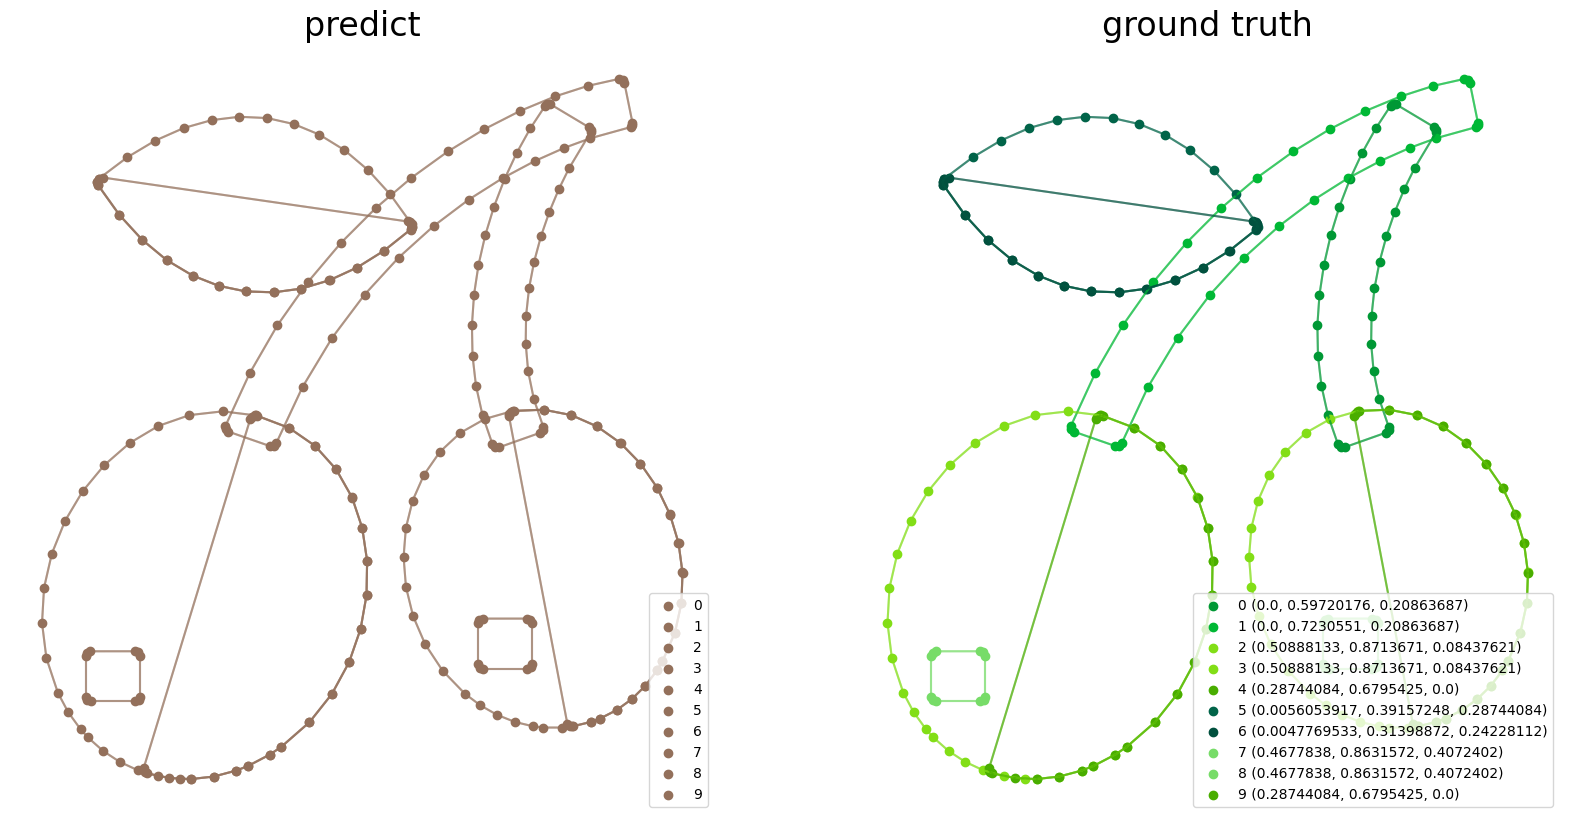

In [31]:
# visualize testing results
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from collections import OrderedDict
import colorsys
import skimage

vis_loader = DataLoader(test_set, batch_size=1, shuffle=False)
model.load_state_dict(torch.load('./best_checkpoint.pth'))
model.eval()

for ii, data in enumerate(vis_loader):
    
    fig = plt.figure("plot", figsize=(20, 10))
    ax = fig.add_subplot(1, 2, 1)
    plt.axis("off")
    
    data = data.to(device)
    out = model(data)
    pos = data.x.cpu().detach().numpy()
    rgb = out[data.cluster].cpu().detach().numpy()
    
    edge = np.transpose(data.edge_index.cpu().detach().numpy())
    clu = data.cluster.cpu().detach().numpy()
    
    for i, ((_, _, _, x, y), (a, b)) in enumerate(zip(pos, rgb)):
        a, b = a*256-128, b*256-128
        r, g, b = skimage.color.lab2rgb([50, a, b])
        plt.scatter(x, y, color=[r, g, b], label=clu[i])
    for n1, n2 in edge:
        x1, y1 = pos[n1, 3:]
        x2, y2 = pos[n2, 3:]
        a, b = rgb[n1] * 256 - 128
        color = skimage.color.lab2rgb([50, a, b])
        l = Line2D([x1,x2], [y1,y2], alpha=0.5, color=color)
        ax.add_line(l)
        
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc="lower right")
    plt.title("predict", size=24)
        
    ax = fig.add_subplot(1, 2, 2)
    plt.axis("off")
    plt.title("ground truth", size=24)
    RGB = data.rgb.cpu().detach().numpy()
    HSV = data.hsv.cpu().detach().numpy()
    for i, ((_, _, _, x, y), (r, g, b), (h, s, v)) in enumerate(zip(pos, RGB, HSV)):
        label = f"{clu[i]} {(r, g, b)}"
        # label = f"{clu[i]} {(h, s, v)}"
        plt.scatter(x, y, color=[r, g, b], label=label)
    for n1, n2 in edge:
        x1, y1 = pos[n1, 3:]
        x2, y2 = pos[n2, 3:]
        l = Line2D([x1,x2], [y1,y2], alpha=0.5, color=RGB[n1])
        ax.add_line(l)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc="lower right")
    
    plt.show()
    plt.close()
    # break
    if ii > 3: break